In [1]:
# !pip install xgboost catboost lightgbm
#hi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import gc
import hashlib

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, KFold, GroupKFold, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score,precision_score, confusion_matrix

import catboost as cb
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# from google.colab import files
# uploaded = files.upload()


In [3]:
# !unzip Financial-Fraud-Detection-main.zip

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# !cp -r /content/Financial-Fraud-Detection-main /content/drive/MyDrive/Colab\ Notebooks/

In [6]:
# !ls "/content/drive/MyDrive/Colab Notebooks/fraud_detection_project"


In [7]:
# Process DeviceInfo, id_30-31 and generate a feature 'has identity'
def id_split(dataframe):
  dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
  dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]
  dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
  dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
  dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
  dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
  dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
  dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
  dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
  dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
  dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
  dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
  dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
  dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
  dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
  dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
  dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
  dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
  dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
  dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
  dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

# Classes that are too sparse are placed in other classes
  dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 100].index), 'device_name'] = "Others"
  dataframe['had_id'] = 1
  gc.collect()
  return dataframe

# Loading Data

In [8]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30',
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [9]:
folder_path = '/content/Financial-Fraud-Detection-main/data/'
train_identity = pd.read_csv(f'{folder_path}raw/train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}raw/train_transaction.csv', usecols=cols+['isFraud'])
test_identity = pd.read_csv(f'{folder_path}raw/test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}raw/test_transaction.csv', usecols=cols)

In [10]:
# Rename columns in test_identity (replace hyphens with underscores in "id-xx" columns)
test_identity.columns = [col.replace("id-", "id_") for col in test_identity.columns]

In [11]:
print(test_identity.columns)

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')


In [12]:
print(train_identity.columns)

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')


In [13]:
# Let's combine the data and work with the whole dataset
X_train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
X_test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [14]:
# TARGET
y_train = X_train['isFraud'].copy()
X_train = X_train.drop(['isFraud'],axis=1)

del train_identity, test_identity, train_transaction, test_transaction; x = gc.collect()

# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 214) test shape (506691, 214)


### Splitting into validation and train

In [15]:
# # Vérifier que X_train et y_train ont le même nombre d'échantillons
# assert len(X_train) == len(y_train), "Les ensembles X_train et y_train n'ont pas le même nombre d'échantillons."

# # Diviser les données en un ensemble d'entraînement et de test avec la même répartition des classes
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# # Afficher les tailles des ensembles de données
# print(f"Ensemble d'entraînement : {X_train.shape[0]} échantillons")
# print(f"Ensemble de test : {X_val.shape[0]} échantillons")

# # Vérifier la répartition des classes dans chaque ensemble
# print(f"Répartition des classes dans le jeu d'entraînement :\n{y_train.value_counts()}")
# print(f"Répartition des classes dans le jeu de validation :\n{y_val.value_counts()}")

# Feature Engineering

In [16]:
X_train = id_split(X_train)
X_test = id_split(X_test)

In [17]:
print(X_train.shape)
print(X_test.shape)

(590540, 219)
(506691, 219)


In [18]:
# New fields have been added
print(X_train['device_name'].value_counts())
print(X_train['device_version'].value_counts())
print(X_train['OS_id_30'].value_counts())
print(X_train['browser_id_31'].value_counts())

device_name
Windows            47722
iOS Device         19782
MacOS              12573
Samsung            12092
Trident             7440
Others              4978
RV                  4385
Motorola            2935
Huawei              2377
LG                  2331
Sony                 575
ZTE                  518
HTC                  406
hi6210sft Build      190
F3213 Build          125
Linux                121
F5121 Build          116
Name: count, dtype: int64
device_version
7.0                7440
NRD90M             5908
MMB29K             1874
MRA58K             1446
MMB29M             1342
                   ... 
4.28.502.2            1
V41020c               1
OPR4.170623.006       1
OPN27.76-12-22        1
HUAWEILDN-LX3         1
Name: count, Length: 293, dtype: int64
OS_id_30
Windows    36739
iOS        19782
Mac        13580
Android     6303
Linux       1136
other         15
func          10
Name: count, dtype: int64
browser_id_31
chrome               76059
mobile               283

In [19]:
X_train['TransactionAmt'] = np.log1p(X_train['TransactionAmt'])
X_test['TransactionAmt'] = np.log1p(X_test['TransactionAmt'])

## Flagging outliers

In [20]:
def compute_outlier_bounds(series):
    valid = series[(series != -999) & (~series.isna())]
    Q1 = valid.quantile(0.25)
    Q3 = valid.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

def add_outlier_flag_from_bounds(df, col, lower, upper):
    df[col + '_is_outlier'] = ((df[col] < lower) | (df[col] > upper)).astype('int8')
    return df

In [21]:
numeric_features = X_train.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns

In [22]:
for col in numeric_features:
    if X_train[col].nunique() > 10:  # skip low-cardinality features
        skew = X_train[col].skew()
        print(f"{col} - skew: {round(skew,2)}")

TransactionID - skew: -0.0
TransactionDT - skew: 0.13
TransactionAmt - skew: 0.49
card1 - skew: -0.04
card2 - skew: -0.2
card3 - skew: 2.02
card5 - skew: -1.22
addr1 - skew: 0.37
addr2 - skew: -14.5
dist1 - skew: 5.11
dist2 - skew: 5.97
C1 - skew: 23.96
C2 - skew: 23.68
C3 - skew: 88.95
C4 - skew: 22.08
C5 - skew: 5.79
C6 - skew: 19.77
C7 - skew: 27.19
C8 - skew: 26.08
C9 - skew: 5.69
C10 - skew: 25.22
C11 - skew: 22.36
C12 - skew: 27.42
C13 - skew: 8.99
C14 - skew: 16.53
D1 - skew: 1.81
D2 - skew: 1.02
D3 - skew: 4.54
D4 - skew: 1.17
D5 - skew: 3.39
D6 - skew: 2.26
D7 - skew: 2.95
D8 - skew: 2.24
D9 - skew: -0.59
D10 - skew: 1.39
D11 - skew: 1.05
D12 - skew: 2.46
D13 - skew: 5.41
D14 - skew: 2.58
D15 - skew: 0.96
V17 - skew: 3.79
V20 - skew: 0.25
V23 - skew: 12.12
V26 - skew: 2.69
V37 - skew: 22.63
V40 - skew: 6.65
V44 - skew: 29.04
V56 - skew: 23.56
V59 - skew: 4.38
V62 - skew: 0.61
V78 - skew: 15.27
V80 - skew: 5.69
V86 - skew: 16.93
V123 - skew: 12.88
V124 - skew: 6.09
V127 - skew:

In [23]:
# Threshold for skewness (you can tweak it)
skew_threshold = 2

# Filter numeric features by skewness
numeric_features_filtered = [
    col for col in numeric_features
    if X_train[col].nunique() > 10 and abs(X_train[col].skew()) > skew_threshold
]

In [24]:
important_features=[
    'C1', 'C10', 'C13', 'C14', 'C1_card2_mean', 'C1_card2_std', 'C2', 'C4', 'C8',
    'ProductCD_R_Day', 'R_emaildomain', 'R_emaildomain_count_full',
    'TransactionAmt_card1_addr1_P_emaildomain_std', 'V121', 'V187', 'V188', 'V210',
    'V257', 'V258', 'V258_ProductID_std', 'V258_R_emaildomain_mean',
    'V258_R_emaildomain_std', 'V258_uid_mean', 'V271', 'V274', 'V294', 'V294_uid_mean',
    'V30', 'V309', 'V48', 'V68', 'V70', 'V89', 'V91', 'addr1_count_full', 'card1',
    'card1_addr1_FE', 'card3_count_full', 'card5', 'card6', 'card6_count_full', 'day',
    'dow', 'email_domain_comp', 'id_02_uid_std', 'id_29', 'uid_C13_ct'
]

In [25]:
outlier_flag_features = list(set(important_features) & set(numeric_features_filtered))
outlier_flag_features.sort()

# Output
print(outlier_flag_features)

['C1', 'C10', 'C13', 'C14', 'C2', 'C4', 'C8', 'V187', 'V188', 'V210', 'V257', 'V258', 'V271', 'V274', 'V294', 'V309']


In [26]:
# Apply to selected features
for col in outlier_flag_features:
    lower, upper = compute_outlier_bounds(X_train[col])
    X_train = add_outlier_flag_from_bounds(X_train, col, lower, upper)
    X_test = add_outlier_flag_from_bounds(X_test, col, lower, upper)  # ✅ SAFE: using train's thresholds

### Extracting Time Features

In [27]:
print(X_test['TransactionDT'][:5])

0    18403224
1    18403263
2    18403310
3    18403310
4    18403317
Name: TransactionDT, dtype: int64


- DT_D (Days)
- DT_W (Weeks)
- DT_M (Months)

In [28]:
START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
X_train['TransactionDT_date'] = X_train['TransactionDT'].apply(lambda x: startdate + datetime.timedelta(seconds=x))
X_test['TransactionDT_date'] = X_test['TransactionDT'].apply(lambda x: startdate + datetime.timedelta(seconds=x))
for df in [X_train, X_test]:
    df['DT_D'] = ((df['TransactionDT_date'].dt.year - 2017) * 365 + df['TransactionDT_date'].dt.dayofyear).astype(np.int16)
    df['DT_W'] = (df['TransactionDT_date'].dt.year - 2017) * 52 + df['TransactionDT_date'].dt.isocalendar().week
    df['DT_M'] = (df['TransactionDT_date'].dt.year - 2017) * 12 + df['TransactionDT_date'].dt.month

## Encoding ProductCD with Count Features Over Time

In [29]:
X_train.ProductCD.value_counts()

,count
ProductCD,
W,439670
C,68519
R,37699
H,33024
S,11628


Recognizing that the various categories of ProductCD behave differently in terms of fraud and time series, we split their count_encoding feature into five indicators

In [30]:
# Merge X_train and y_train into train
train = X_train.copy()  # Copy X_train
train['isFraud'] = y_train  # Add y_train as a new column

In [31]:
# W
te = train.groupby(['ProductCD','DT_D'])['isFraud'].agg(['count','mean'])
te.reset_index(inplace=True)
train['ProductCD_W_Day'] = pd.merge(train[['ProductCD','DT_D']],te[['ProductCD','DT_D','count']],on = ['ProductCD','DT_D'],how='left')['count']
te = X_test.groupby(['ProductCD','DT_D'])['TransactionAmt'].agg(['count','mean'])
te.reset_index(inplace=True)
X_test['ProductCD_W_Day'] = pd.merge(X_test[['ProductCD','DT_D']],te[['ProductCD','DT_D','count']],on = ['ProductCD','DT_D'],how='left')['count']
train.loc[train.ProductCD != 'W','ProductCD_W_Day'] = 0
X_test.loc[X_test.ProductCD != 'W','ProductCD_W_Day'] = 0

# C
te = train.groupby(['ProductCD','DT_D'])['isFraud'].agg(['count','mean'])
te.reset_index(inplace=True)
train['ProductCD_C_Day'] = pd.merge(train[['ProductCD','DT_D']],te[['ProductCD','DT_D','count']],on = ['ProductCD','DT_D'],how='left')['count']
te = X_test.groupby(['ProductCD','DT_D'])['TransactionAmt'].agg(['count','mean'])
te.reset_index(inplace=True)
X_test['ProductCD_C_Day'] = pd.merge(X_test[['ProductCD','DT_D']],te[['ProductCD','DT_D','count']],on = ['ProductCD','DT_D'],how='left')['count']
train.loc[train.ProductCD != 'C','ProductCD_C_Day'] = 0
X_test.loc[X_test.ProductCD != 'C','ProductCD_C_Day'] = 0

# R
te = train.groupby(['ProductCD','DT_D'])['isFraud'].agg(['count','mean'])
te.reset_index(inplace=True)
train['ProductCD_R_Day'] = pd.merge(train[['ProductCD','DT_D']],te[['ProductCD','DT_D','count']],on = ['ProductCD','DT_D'],how='left')['count']
te = X_test.groupby(['ProductCD','DT_D'])['TransactionAmt'].agg(['count','mean'])
te.reset_index(inplace=True)
X_test['ProductCD_R_Day'] = pd.merge(X_test[['ProductCD','DT_D']],te[['ProductCD','DT_D','count']],on = ['ProductCD','DT_D'],how='left')['count']
train.loc[train.ProductCD != 'R','ProductCD_R_Day'] = 0
X_test.loc[X_test.ProductCD != 'R','ProductCD_R_Day'] = 0

# H
te = train.groupby(['ProductCD','DT_D'])['isFraud'].agg(['count','mean'])
te.reset_index(inplace=True)
train['ProductCD_H_Day'] = pd.merge(train[['ProductCD','DT_D']],te[['ProductCD','DT_D','count']],on = ['ProductCD','DT_D'],how='left')['count']
te = X_test.groupby(['ProductCD','DT_D'])['TransactionAmt'].agg(['count','mean'])
te.reset_index(inplace=True)
X_test['ProductCD_H_Day'] = pd.merge(X_test[['ProductCD','DT_D']],te[['ProductCD','DT_D','count']],on = ['ProductCD','DT_D'],how='left')['count']
train.loc[train.ProductCD != 'H','ProductCD_H_Day'] = 0
X_test.loc[X_test.ProductCD != 'H','ProductCD_H_Day'] = 0

# S
te = train.groupby(['ProductCD','DT_D'])['isFraud'].agg(['count','mean'])
te.reset_index(inplace=True)
train['ProductCD_S_Day'] = pd.merge(train[['ProductCD','DT_D']],te[['ProductCD','DT_D','count']],on = ['ProductCD','DT_D'],how='left')['count']
te = X_test.groupby(['ProductCD','DT_D'])['TransactionAmt'].agg(['count','mean'])
te.reset_index(inplace=True)
X_test['ProductCD_S_Day'] = pd.merge(X_test[['ProductCD','DT_D']],te[['ProductCD','DT_D','count']],on = ['ProductCD','DT_D'],how='left')['count']
train.loc[train.ProductCD != 'S','ProductCD_S_Day'] = 0
X_test.loc[X_test.ProductCD != 'S','ProductCD_S_Day'] = 0

In [32]:
# Five new fields have been added
print(train.columns[-5:].tolist())

['ProductCD_W_Day', 'ProductCD_C_Day', 'ProductCD_R_Day', 'ProductCD_H_Day', 'ProductCD_S_Day']


## Normalize D Columns

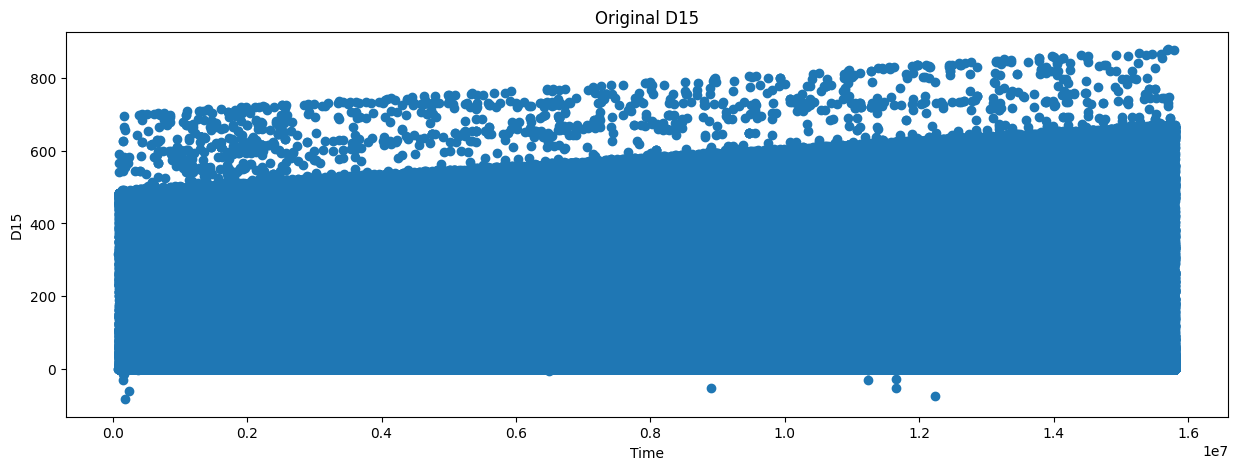

In [33]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(train.TransactionDT,train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [34]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    train['D'+str(i)] =  train['D'+str(i)] - train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60)

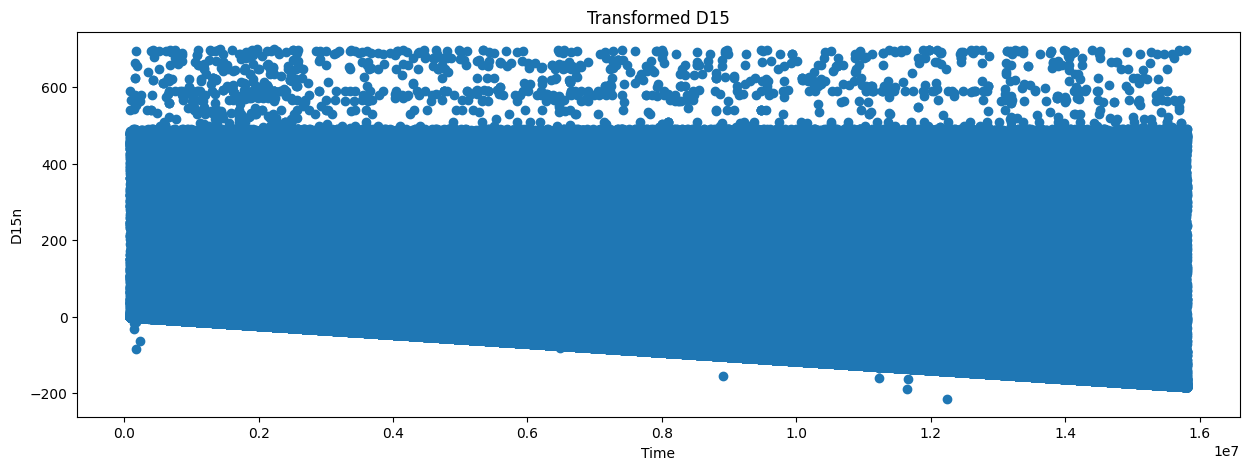

In [35]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(train.TransactionDT,train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

## Label Encoding

In [36]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (str(train[f].dtype)=='category')|(train[f].dtype=='object'):
        df_comb = pd.concat([train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')

CPU times: user 2.03 s, sys: 20.6 ms, total: 2.05 s
Wall time: 2.04 s


## Missing Values
Impute all missing values with -999 which is very fast and model can still find some pattern instead of losing information by dropping them.

In [37]:
# Seuil de tolérance : ici 90%
threshold = 0.90

# Calcul du ratio de valeurs manquantes par colonne
missing_ratio = train.isnull().mean()

# Colonnes à supprimer
cols_to_drop = missing_ratio[missing_ratio > threshold].index

# Affichage des colonnes concernées
print(f"Nombre de colonnes à supprimer : {len(cols_to_drop)}")
print("Colonnes supprimées (NaN > 90%) :", list(cols_to_drop))

Nombre de colonnes à supprimer : 10
Colonnes supprimées (NaN > 90%) : ['dist2', 'D7', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26']


In [38]:
# Suppression des colonnes
drop = []
drop += list(cols_to_drop)

In [39]:
train.fillna(-999,inplace = True)
X_test.fillna(-999,inplace = True)

## Encoding Functions

In [40]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-999] = -999
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

# LABEL ENCODE
def encode_LE(col,train=train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000:
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=train, test_df=X_test,
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')

                if fillna:
                    train_df[new_col_name].fillna(-999,inplace=True)
                    test_df[new_col_name].fillna(-999,inplace=True)

                print("'"+new_col_name+"'",', ',end='')

# COMBINE FEATURES
def encode_CB(col1,col2,df1=train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')

# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=train, test_df=X_test):
    for main_column in main_columns:
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [41]:
%%time
# TRANSACTION AMT CENTS
train['cents'] = (train['TransactionAmt'] - np.floor(train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 5.12 s, sys: 108 ms, total: 5.23 s
Wall time: 5.23 s


## UID

In [42]:
train['day'] = train.TransactionDT / (24*60*60)
train['uid'] = train.card1_addr1.astype(str)+'_'+np.floor(train.day-train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

## Group Aggregation Features

In [43]:
%%time
# FREQUENCY ENCODE UID
encode_FE(train,X_test,['uid'])
# AGGREGATE
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG2(['C13','V314'], ['uid'], train_df=train, test_df=X_test)
# AGGREATE
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=train, test_df=X_test)
# NEW FEATURE
train['outsider15'] = (np.abs(train.D1-train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15
CPU times: user 1min 33s, sys: 311 ms, total: 1min 34s
Wall time: 1min 37s


## Creating new features

In [44]:
# Use card series and open_card fields are used as identifiers only UserID
train['open_card'] = train.DT_D - train['D1']
train['first_tran'] = train.DT_D - train['D2']
X_test['open_card'] = X_test.DT_D - X_test['D1']
X_test['first_tran'] = X_test.DT_D - X_test['D2']

# train['uid1'] = train['card1'].astype(str) +' '+ train['card2'].astype(str)+' '+ train['card3'].astype(str)+' '+train['card4'].astype(str)+' '+ train['card5'].astype(str)+' '+ train['card6'].astype(str) +' '+ train['addr1'].astype(str)+' '+train['addr2'].astype(str)+' '+train['open_card'].astype(str)
# X_test['uid1'] = X_test['card1'].astype(str) +' '+ X_test['card2'].astype(str)+' '+ X_test['card3'].astype(str)+' '+ X_test['card4'].astype(str)+' '+ X_test['card5'].astype(str)+' '+ X_test['card6'].astype(str) +' '+ X_test['addr1'].astype(str)+' '+X_test['addr2'].astype(str)+' '+X_test['open_card'] .astype(str)

In [45]:
print(train['uid'].nunique())
print(X_test['uid'].nunique())

218030
198035


In [46]:
# Identify a device using id_30, id_31, id_32, id_33, DeviceType, DeviceInfo
def device_hash(x):
    s =  str(x['id_30'])+str(x['id_31'])+str(x['id_32'])+str(x['id_33'])+str( x['DeviceType'])+ str(x['DeviceInfo'])
    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

In [47]:
for df in [train,X_test]:df['device_hash'] = df.apply(lambda x: device_hash(x), axis=1)

In [48]:
# Number of devices with the same user
concat_df = pd.concat([train[['uid','device_hash']],X_test[['uid','device_hash']]])
tmp = concat_df.groupby('uid')['device_hash'].agg(['nunique'])

In [49]:
train['uid_device_nunique'] = train.uid.map(tmp.to_dict()['nunique'])
X_test['uid_device_nunique'] = X_test.uid.map(tmp.to_dict()['nunique'])

In [50]:
# Number of user with the same devices
tmp = concat_df.groupby('device_hash')['uid'].agg(['nunique'])
train['device_uid_nunique'] = train.device_hash.map(tmp.to_dict()['nunique'])
X_test['device_uid_nunique'] = X_test.device_hash.map(tmp.to_dict()['nunique'])

In [51]:
del concat_df

In [52]:
# Get number of non-zero decimal digits
def change(dec):
    dec = np.round(dec,3)
    num = 3
    dec = int(np.round(np.round(dec,3)*1000))
    while(dec % 10 ==0):
        num = num-1
        dec = dec /10
    if num<0:
        num = 0
    return num

train['decimal_digit'] = train["TransactionAmt"].map(change)
X_test['decimal_digit'] = X_test['TransactionAmt'].map(change)

gc.collect()

0

In [53]:
# Fill missing value with zero
train['had_id'] = train['had_id'].fillna(0)
X_test['had_id'] = X_test['had_id'].fillna(0)

In [54]:
# Subdivide the time into days of the week and hours of the day.
train['dow'] = train['TransactionDT_date'].dt.dayofweek
train['hour'] = train['TransactionDT_date'].dt.hour
X_test['dow'] = X_test['TransactionDT_date'].dt.dayofweek
X_test['hour'] = X_test['TransactionDT_date'].dt.hour
train['email_domain_comp'] = (train['P_emaildomain'].values == train['R_emaildomain'].values).astype(int)
X_test['email_domain_comp'] = (X_test['P_emaildomain'].values == X_test['R_emaildomain'].values).astype(int)
# train.drop(['D9'],axis=1,inplace=True)
# X_test.drop(['D9'],axis=1,inplace=True)
drop += ['D9']

In [55]:
# New Features
def hourFeature(hour):
    if hour>3 and hour < 11:
        return 3
    if hour ==11 or hour==18:
        return 1
    if hour==2 or hour==3 or hour==23:
        return 2
    else:
        return 0

In [56]:
train['alertFeature'] = train['hour'].apply(hourFeature)
X_test['alertFeature'] = X_test['hour'].apply(hourFeature)

In [57]:
# Categorical Variables
cat_columns = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9','hour','dow','device_name', 'device_version', 'OS_id_30',  'browser_id_31']
# Count Numerical
count_columns = ['id_13','id_14','id_17','id_18','id_19','id_20','id_21','id_22','id_24','id_25','id_26','id_30','id_31','id_33',
                 'DeviceInfo','card6','P_emaildomain','R_emaildomain','card1','card2','card3','card5','addr1','addr2','hour','device_version',
                 'OS_id_30','browser_id_31']

In [58]:
# # COLUMNS WITH STRINGS
# str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
#             'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30',
#             'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

# # FIRST 53 COLUMNS
# cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
#        'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
#        'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
#        'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
#        'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
#        'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
#        'M5', 'M6', 'M7', 'M8', 'M9']


In [59]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 174 FEATURES.


array(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1',
       'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1',
       'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7',
       'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2',
       'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V3', 'V4', 'V6',
       'V8', 'V11', 'V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27',
       'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54',
       'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78',
       'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V107', 'V108', 'V111',
       'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 'V129',
       'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156', 'V162',
       'V165', 'V160', 'V166', 'V178', 'V176', 'V173', 'V182', 'V187',
    

In [60]:
# for f in cat_columns:
#   if f not in str_type:
#       lbl = preprocessing.LabelEncoder()
#       lbl.fit(list(train[f].astype(str)) + list(X_test[f].astype(str)))
#       train[f] = lbl.transform(list(train[f].astype(str)))
#       X_test[f] = lbl.transform(list(X_test[f].astype(str)))

In [61]:
# Count encoding
for i in count_columns:
  train[i+'_count_full'] = train[i].map(pd.concat([train[i], X_test[i]], ignore_index=True).value_counts(dropna=False))
  X_test[i+'_count_full'] = X_test[i].map(pd.concat([train[i], X_test[i]], ignore_index=True).value_counts(dropna=False))

In [62]:
train_len = len(train)

In [63]:
# Calculate the number of transactions in hours and days
train_test_all = pd.concat([train[['TransactionDT_date','TransactionAmt']],X_test[['TransactionDT_date','TransactionAmt']]],ignore_index=True,sort=False)
train_test_all['day_count'] = train_test_all.groupby(train_test_all.TransactionDT_date.dt.date)['TransactionAmt'].transform('count')
train_test_all['hour_count'] = train_test_all.groupby(train_test_all.TransactionDT_date.map(lambda x:str(x)[:13]))['TransactionAmt'].transform('count')
train['day_count'] = train_test_all[:train_len].day_count.tolist()
X_test['day_count'] = train_test_all[train_len:].day_count.tolist()
train['hour_count'] = train_test_all[:train_len].hour_count.tolist()
X_test['hour_count'] = train_test_all[train_len:].hour_count.tolist()

In [64]:
# Identify commodity ID by price category
temp123 = ['TransactionAmt__ProductCD']
for feature in temp123:
  f1, f2 = feature.split('__')
  train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
  X_test[feature] = X_test[f1].astype(str) + '_' + X_test[f2].astype(str)
  le = LabelEncoder()
  le.fit(list(train[feature].astype(str).values) + list(X_test[feature].astype(str).values))
  train[feature] = le.transform(list(train[feature].astype(str).values))
  X_test[feature] = le.transform(list(X_test[feature].astype(str).values))
train.rename(columns = {'TransactionAmt__ProductCD':'ProductID'},inplace=True)
X_test.rename(columns = {'TransactionAmt__ProductCD':'ProductID'},inplace=True)
for i in ['ProductID']:
  train[i+'_count_full'] = train[i].map(pd.concat([train[i], X_test[i]], ignore_index=True).value_counts(dropna=False))
  X_test[i+'_count_full'] = X_test[i].map(pd.concat([train[i], X_test[i]], ignore_index=True).value_counts(dropna=False))

In [65]:
# Similarly, continue to do some crossover categories
temp = ['DeviceInfo__P_emaildomain',
        'card1__card5',
        'card2__id_20',
        'card5__P_emaildomain',
        'addr1__card1',
        'addr1__addr2',
        'card1__card2',
        'card2__addr1',
        'card1__P_emaildomain',
        'card2__P_emaildomain',
        'addr1__P_emaildomain',
        'DeviceInfo__id_31',
        'DeviceInfo__id_20',
        'DeviceType__id_31',
        'DeviceType__id_20',
        'DeviceType__P_emaildomain',
        'card1__M4',
        'card2__M4',
        'addr1__M4',
        'P_emaildomain__M4',
       'uid__ProductID',
       'uid__DeviceInfo']
for feature in temp:
  f1, f2 = feature.split('__')
  train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
  X_test[feature] = X_test[f1].astype(str) + '_' + X_test[f2].astype(str)
  le = LabelEncoder()
  le.fit(list(train[feature].astype(str).values) + list(X_test[feature].astype(str).values))
  train[feature] = le.transform(list(train[feature].astype(str).values))
  X_test[feature] = le.transform(list(X_test[feature].astype(str).values))

for i in temp:
  train[i+'_count_full'] = train[i].map(pd.concat([train[i], X_test[i]], ignore_index=True).value_counts(dropna=False))
  X_test[i+'_count_full'] = X_test[i].map(pd.concat([train[i], X_test[i]], ignore_index=True).value_counts(dropna=False))

In [66]:
# Cross some categories and continuous variables
con_fea = ['V258','C1','C14','C13','TransactionAmt','D15','D2','id_02','dist1','V294','C11']
cat_fea = ['card1','card2','addr1','card4','R_emaildomain','P_emaildomain','ProductID','uid']
train_test = pd.concat([train[con_fea+cat_fea],X_test[con_fea+cat_fea]],ignore_index=True,sort=False)

for cont in con_fea:
  for cat in cat_fea:
    train[cont+'_'+cat+'_mean'] = train_test[cont].map(lambda x:np.nan if x==-999 else x).groupby(train_test[cat]).transform('mean')[:train_len].tolist()
    train[cont+'_'+cat+'_std'] = train_test[cont].map(lambda x:np.nan if x==-999 else x).groupby(train_test[cat]).transform('std')[:train_len].tolist()
    X_test[cont+'_'+cat+'_mean'] = train_test[cont].map(lambda x:np.nan if x==-999 else x).groupby(train_test[cat]).transform('mean')[train_len:].tolist()
    X_test[cont+'_'+cat+'_std'] =  train_test[cont].map(lambda x:np.nan if x==-999 else x).groupby(train_test[cat]).transform('std')[train_len:].tolist()

## Feature Selection

In [67]:
cols = list( train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)

# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [68]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 548 FEATURES.


array(['TransactionID', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2',
       'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2',
       'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M6', 'M7', 'M8', 'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13',
       'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37',
       'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62',
       'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86',
       'V88', 'V89', 'V91', 'V107', 'V108', 'V111', 'V115', 'V117',
       'V120', 'V121', 'V123', 'V124', 'V127', 'V129', 'V130', 'V136',
       'V138', 'V139', 'V142', 'V147', 'V156', 'V160', 'V162', 'V165',
       'V166', 'V169', 'V171', 'V173', 'V175', 'V176', 'V178', 'V180',
       'V182', 'V185', 'V187', 'V188', 'V198', 'V203', 'V205', 'V207',
       

In [69]:
del df
del train_test
del train_test_all
gc.collect()

30

In [70]:
drop += ['DeviceInfo','device_version','DT_D','DT_W','DT_M','TransactionAmt_ProductID_mean']
# train.drop(['DeviceInfo','device_version','DT_D','DT_W','DT_M','TransactionAmt_ProductID_mean'],axis=1,inplace=True)
# X_test.drop(['DeviceInfo','device_version','DT_D','DT_W','DT_M','TransactionAmt_ProductID_mean'],axis=1,inplace=True)

In [71]:
# Remove non important features
drop += ['C1_P_emaildomain_mean', 'id_17_count_full', 'id_02_R_emaildomain_std',
        'C11_P_emaildomain_mean',
        'TransactionAmt_R_emaildomain_std',
        'V258_card4_mean','id_18_count_full','id_02_R_emaildomain_mean',
        'C1_R_emaildomain_mean', 'C13_R_emaildomain_std',
        'browser_id_31', 'D15_R_emaildomain_std',
        'C14_R_emaildomain_std', 'V58', 'C1_R_emaildomain_std',
        'C11_P_emaildomain_std',
        'C1_card4_mean','ProductCD', 'TransactionAmt_card4_mean','V258_card4_std',
        'id_26_count_full','C1_card4_std', 'id_25_count_full',
        'dist1_card4_std', 'addr2_count_full','TransactionAmt_card4_std', 'C11_R_emaildomain_mean',
        'D15_card4_std', 'DeviceType',
        'dist1_card4_mean',
         'id_21_count_full', 'C11_R_emaildomain_std',  'C14_card4_mean',
        'C14_card4_std','id_02_card4_mean', 'id_02_card4_std', 'C13_card4_mean',
        'id_24_count_full', 'D2_revised_card4_mean', 'had_id', 'D2_card4_std','TransactionAmt_ProductID_std',
        'id_22_count_full', 'C13_card4_std','V294_card4_std', 'V294_card4_mean', 'dist1_R_emaildomain_mean',
        'C11_card4_mean', 'C11_card4_std', 'dist1_R_emaildomain_std',  'D15_card4_mean']

In [72]:
# # Remove non important features
# drop += ['V256', 'V223', 'V19', 'V244', 'V324', 'V37', 'V200', 'card3', 'C1_P_emaildomain_mean', 'V131', 'V35', 'id_17_count_full',
#         'id_17', 'V30', 'V163', 'V81', 'V332', 'V164', 'D7', 'id_02_R_emaildomain_std', 'V336', 'M9', 'V301', 'V251', 'M8',
#         'V275', 'V5', 'V272', 'V331', 'V215', 'V291', 'V129', 'C11_P_emaildomain_mean', 'id_34', 'V160', 'V139', 'V124', 'V159',
#         'V274', 'V59', 'V126', 'V52', 'V79', 'V271', 'V24', 'V137', 'V286', 'TransactionAmt_R_emaildomain_std', 'V335', 'V115',
#         'V198', 'V234', 'V298', 'V43', 'V258_card4_mean', 'V264', 'OS_id_30_count_full', 'V267', 'V169', 'V217', 'C3', 'V23',
#         'V287', 'id_18_count_full', 'V96', 'V208', 'card4', 'id_32', 'V232', 'V188', 'V4', 'V7', 'id_38', 'id_02_R_emaildomain_mean',
#         'V293', 'V219', 'V259', 'V276', 'C1_R_emaildomain_mean', 'V279', 'V102', 'V253', 'C13_R_emaildomain_std', 'V245', 'V73',
#         'browser_id_31', 'V74', 'V322', 'V209', 'V203', 'V273', 'V221', 'V40', 'V242', 'V289', 'D15_R_emaildomain_std',
#         'C14_R_emaildomain_std', 'V150', 'V316', 'V239', 'V265', 'V278', 'V166', 'V172', 'V132', 'V93', 'V58', 'C1_R_emaildomain_std',
#         'V29', 'V300', 'V134', 'V254', 'V145', 'V141', 'C11_P_emaildomain_std', 'V292', 'V210', 'V231', 'V280', 'V158', 'V123', 'V135',
#         'V220', 'V39', 'V26', 'V238', 'id_11', 'V319', 'V125', 'id_37', 'V206', 'C1_card4_mean', 'V94', 'V304', 'V57', 'V270', 'V33',
#         'V170', 'V202', 'V218', 'V108', 'V303', 'V213', 'V222', 'V64', 'V263', 'V326', 'V10', 'V147', 'V101', 'V142', 'V97', 'V214',
#         'V105', 'V60', 'V171', 'V329', 'ProductCD', 'V216', 'V34', 'V25', 'V6', 'TransactionAmt_card4_mean', 'V212', 'V250', 'V3',
#         'V63', 'V194', 'id_36', 'V178', 'V42', 'V85', 'V193', 'V290', 'id_23', 'V258_card4_std', 'V15', 'V288', 'id_15', 'V182', 'V2',
#         'V192', 'V260', 'V235', 'id_26_count_full', 'V138', 'id_24', 'id_10', 'C1_card4_std', 'V11', 'id_08', 'id_25_count_full', 'id_07',
#         'V167', 'V51', 'V229', 'V248', 'V197', 'V230', 'V144', 'V233', 'V157', 'dist1_card4_std', 'V284', 'V140', 'addr2_count_full', 'V154',
#         'V22', 'V204', 'M1', 'V71', 'V211', 'V255', 'V72', 'TransactionAmt_card4_std', 'V1', 'V80', 'V184', 'V299', 'C11_R_emaildomain_mean',
#         'V173', 'V177', 'id_04', 'D15_card4_std', 'V180', 'V228', 'V151', 'V186', 'OS_id_30', 'V109', 'DeviceType', 'V18', 'V17',
#         'id_26', 'V247', 'V9', 'V191', 'V148', 'V65', 'V196', 'id_21', 'V297', 'V46', 'V338', 'addr2', 'V95', 'V92', 'dist1_card4_mean',
#         'V334', 'V100', 'id_25', 'V179', 'V104', 'V116', 'V16', 'V183', 'id_21_count_full', 'V302', 'V199', 'V227', 'C11_R_emaildomain_std',
#         'V176', 'V249', 'V237', 'V327', 'id_16', 'V155', 'V8', 'V252', 'V175', 'V339', 'V330', 'V181', 'V190', 'C14_card4_mean', 'V14', 'V337',
#         'C14_card4_std', 'id_35', 'id_02_card4_mean', 'V110', 'id_12', 'V226', 'V168', 'V21', 'V153', 'V195', 'id_02_card4_std', 'V236', 'V174',
#         'id_28', 'V84', 'V32', 'V106', 'V41', 'V111', 'V112', 'V114', 'V146', 'V328', 'V50', 'id_29', 'C13_card4_mean', 'V103', 'V98', 'V121',
#         'id_24_count_full', 'D2_revised_card4_mean', 'had_id', 'V113', 'D2_card4_std', 'V240', 'TransactionAmt_ProductID_std', 'V185',
#         'id_22_count_full', 'id_22', 'V31', 'C13_card4_std', 'V68', 'V88', 'V294_card4_std', 'V294_card4_mean', 'V122', 'dist1_R_emaildomain_mean',
#         'V118', 'V269', 'V107', 'V305', 'V117', 'V119', 'V120', 'C11_card4_mean', 'C11_card4_std', 'dist1_R_emaildomain_std', 'V89', 'V241', 'id_27',
#         'V325', 'V28', 'D15_card4_mean', 'V27']

In [73]:
print(len(drop))

68


In [74]:
drop1 = drop[:200]
drop2 = drop[200:]

train.drop(drop1,axis=1,inplace=True, errors='ignore')
X_test.drop(drop1,axis=1,inplace=True, errors='ignore')
train.drop(drop2,axis=1,inplace=True, errors='ignore')
X_test.drop(drop2,axis=1,inplace=True, errors='ignore')

In [75]:
print(train.columns)

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'V294_uid_std', 'C11_card1_mean', 'C11_card1_std', 'C11_card2_mean',
       'C11_card2_std', 'C11_addr1_mean', 'C11_addr1_std',
       'C11_ProductID_mean', 'C11_ProductID_std', 'C11_uid_std'],
      dtype='object', length=507)


In [76]:
fraud_count = train[train['isFraud'] == 1].shape[0]
Nofraud_count = train[train['isFraud'] == 0].shape[0]
print(f"Nombre d'instances frauduleuses : {fraud_count}; non frauduleuses: {Nofraud_count}")

Nombre d'instances frauduleuses : 20663; non frauduleuses: 569877


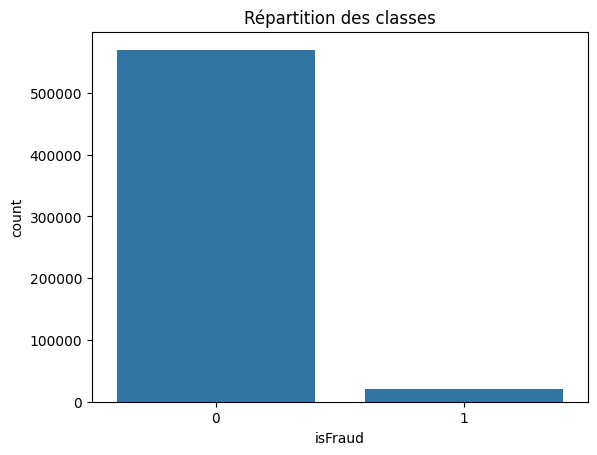

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=train['isFraud'])
plt.title("Répartition des classes")
plt.show()


In [78]:
X_train = train.drop(['TransactionID','isFraud','TransactionDT','TransactionDT_date','uid'],axis=1)
X_test = X_test.drop(['TransactionID','TransactionDT','TransactionDT_date','uid'],axis=1)

In [79]:
# del train,test

In [80]:
print(X_train.shape)
print(X_test.shape)

(590540, 502)
(506691, 502)


In [81]:
cat = ['uid','id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
       'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
       'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9','hour','dow','device_name', 'OS_id_30',  'browser_id_31','ProductID',
       'DeviceInfo__P_emaildomain', 'card1__card5', 'card2__id_20','card5__P_emaildomain', 'addr1__card1','addr1__addr2','card1__card2','card2__addr1','card1__P_emaildomain',
        'card2__P_emaildomain','addr1__P_emaildomain','DeviceInfo__id_31','DeviceInfo__id_20','DeviceType__id_31','DeviceType__id_20','DeviceType__P_emaildomain',
        'card1__M4','card2__M4','addr1__M4','P_emaildomain__M4','uid__ProductID','uid__DeviceInfo']


In [82]:
cols += ['hour','dow','device_name', 'OS_id_30',  'browser_id_31','ProductID',
       'DeviceInfo__P_emaildomain', 'card1__card5', 'card2__id_20','card5__P_emaildomain', 'addr1__card1','addr1__addr2','card1__card2','card2__addr1','card1__P_emaildomain',
        'card2__P_emaildomain','addr1__P_emaildomain','DeviceInfo__id_31','DeviceInfo__id_20','DeviceType__id_31','DeviceType__id_20','DeviceType__P_emaildomain',
        'card1__M4','card2__M4','addr1__M4','P_emaildomain__M4']

In [83]:
for i in drop:
  if i in cat:
    cat.remove(i)

In [84]:
X_train.drop(['device_hash'],axis=1,inplace=True)
X_test.drop(['device_hash'],axis=1,inplace=True)

In [85]:
for i in str_type:
  if i not in cat:
    cat+=[i]

In [86]:
from sklearn.model_selection import train_test_split

# Vérifier que X_train et y_train ont le même nombre d'échantillons
assert len(X_train) == len(y_train), "Les ensembles X_train et y_train n'ont pas le même nombre d'échantillons."

# Diviser les données en un ensemble d'entraînement et de test avec la même répartition des classes
X_trainn, X_test5, y_trainn, y_test5 = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Afficher les tailles des ensembles de données
print(f"Ensemble d'entraînement : {X_trainn.shape[0]} échantillons")
print(f"Ensemble de test : {X_test5.shape[0]} échantillons")

# Vérifier la répartition des classes dans chaque ensemble
print(f"Répartition des classes dans le jeu d'entraînement :\n{y_trainn.value_counts()}")
print(f"Répartition des classes dans le jeu de test :\n{y_test5.value_counts()}")


Ensemble d'entraînement : 472432 échantillons
Ensemble de test : 118108 échantillons
Répartition des classes dans le jeu d'entraînement :
isFraud
0    455902
1     16530
Name: count, dtype: int64
Répartition des classes dans le jeu de test :
isFraud
0    113975
1      4133
Name: count, dtype: int64


In [87]:
X_trainn.to_pickle(f'{folder_path}processed/X_train2.pkl')
X_test5.to_pickle(f'{folder_path}processed/X_test2.pkl')
y_test5.to_pickle(f'{folder_path}processed/y_test2.pkl')
y_trainn.to_frame().to_pickle(f'{folder_path}processed/y_train2.pkl')

# Model

In [88]:
X_train = pd.read_pickle(f'{folder_path}processed/X_train2.pkl')
X_val = pd.read_pickle(f'{folder_path}processed/X_test2.pkl')
y_val =pd.read_pickle(f'{folder_path}processed/y_test2.pkl')
y_train = pd.read_pickle(f'{folder_path}processed/y_train2.pkl')
y_train = y_train.isFraud

In [89]:
cat = set(cat) & set(X_train.columns)

In [90]:
for column in cat:
    train_set = set(X_train[column])
    test_set = set(X_test[column])
    tt = train_set.intersection(test_set)
    print('----------------------------------------')
    print(column)
    print(f'train:{len(tt)/len(train_set)}')
    print(f'test:{len(tt)/len(test_set)}')
    X_train[column] = X_train[column].map(lambda x: -999 if x not in tt else x)
    X_test[column] = X_test[column].map(lambda x: -999 if x not in tt else x)

----------------------------------------
id_32
train:0.8
test:0.6666666666666666
----------------------------------------
id_31
train:0.728
test:0.6691176470588235
----------------------------------------
DeviceInfo__id_31
train:0.1389284986759014
test:0.1314318751204471
----------------------------------------
M3
train:1.0
test:1.0
----------------------------------------
DeviceType__id_31
train:0.7346938775510204
test:0.6708074534161491
----------------------------------------
id_38
train:1.0
test:1.0
----------------------------------------
id_36
train:1.0
test:1.0
----------------------------------------
id_33
train:0.7552742616033755
test:0.4578005115089514
----------------------------------------
OS_id_30
train:1.0
test:1.0
----------------------------------------
card2__P_emaildomain
train:0.7750580945003873
test:0.7955159802830338
----------------------------------------
id_37
train:1.0
test:1.0
----------------------------------------
id_14
train:0.96
test:0.8571428571428571
-

In [91]:
# from sklearn.impute import SimpleImputer
# # Before CV - Analyze and track missing values
# missing_stats = pd.DataFrame({
#     'column': X_train.columns,
#     'missing_pct': X_train.isna().mean(),
#     'was_imputed': X_train.isna().any()
# })

# # Show columns with missing values that will be imputed
# print("Columns to be imputed:")
# print(missing_stats[missing_stats['was_imputed']].sort_values('missing_pct', ascending=False))

# # Initialize and fit imputer on ALL training data first
# global_imputer = SimpleImputer(strategy='median')
# X_train = pd.DataFrame(global_imputer.fit_transform(X_train),
#                               columns=X_train.columns)

# # Apply same imputation to test data
# X_test = pd.DataFrame(global_imputer.transform(X_test),
#                              columns=X_test.columns)

# # Verify no missing values remain
# assert X_train.isna().sum().sum() == 0, "Train still has missing values!"
# assert X_test.isna().sum().sum() == 0, "Test still has missing values!"

## Reducing Memory Usage

In [92]:
## Memory Reducer
# :df pandas dataframe to reduce size
# type: pd.DataFrame()
# :verbose
# type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [93]:
%%time
X_train = reduce_mem_usage(X_train)

Mem. usage decreased to 493.35 Mb (70.0% reduction)
CPU times: user 1.99 s, sys: 38.9 ms, total: 2.03 s
Wall time: 2.04 s


## Extreme Gradient Boosting (XGBoost)

In [94]:
fraud_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

### XGBoost model training

In [ ]:
xgb_model = xgb.XGBClassifier(
    n_estimators=5000,
    max_depth=10,
    learning_rate=0.12526307664736916,
    random_state=0,
    subsample=0.79155511238352,
    colsample_bytree=0.6067786481189409,
    min_child_weight=3,
    reg_alpha=1,
    reg_lambda=0.6,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='auc',
    scale_pos_weight=fraud_ratio *1.2,
    early_stopping_rounds=300,
    enable_categorical=True,
    missing=-999
)

print("\nTraining XGBoost Model...\n")
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)


Training XGBoost Model...



In [ ]:
import joblib

joblib.dump(xgb_model, '/content/Financial-Fraud-Detection-main/models/xgb_model.pkl')
xgb_model.save_model('/content/Financial-Fraud-Detection-main/models/xgb_model.json')

### Predictions

In [ ]:
xgb_val_preds = xgb_model.predict_proba(X_val)[:, 1]
xgb_test_preds = xgb_model.predict_proba(X_test)[:, 1]

print("XGBOOST")
xgb_probs = xgb_model.predict_proba(X_val)[:, 1]
xgb_preds = xgb_model.predict(X_val)

xgb_auc = roc_auc_score(y_val, xgb_probs)
xgb_f1 = f1_score(y_val, xgb_preds)
xgb_recall = recall_score(y_val, xgb_preds)
xgb_precision = precision_score(y_val, xgb_preds)
xgb_conf_matrix = confusion_matrix(y_val, xgb_preds)

print(f"AUC = {xgb_auc:.4f}, F1 = {xgb_f1:.4f}, Recall = {xgb_recall:.4f}, Precision = {xgb_precision:.4f}")
print("Confusion Matrix:")
print(xgb_conf_matrix)

## Catboost

### CatBoost Model Training

In [ ]:
catboost_model = cb.CatBoostClassifier(
    iterations=10000,
    depth=11,
    learning_rate=0.124,
    random_seed=0,
    l2_leaf_reg=1,  # Regularization
    bagging_temperature=0.6,  # Similar to reg_lambda
    auto_class_weights="Balanced",  # Handles imbalance automatically
    eval_metric="AUC",
    early_stopping_rounds=300,
    # task_type="GPU",  # Using GPU if available
    nan_mode="Min",
    verbose=50
)

print("\nTraining CatBoost Model...\n")
catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100)

In [ ]:
joblib.dump(catboost_model, '/content/Financial-Fraud-Detection-main/models/cat_model.pkl')
catboost_model.save_model('/content/Financial-Fraud-Detection-main/models/cat_model.cbm')  # Binary format

### Predictions

In [ ]:
cat_val_preds = catboost_model.predict_proba(X_val)[:, 1]
cat_test_preds = catboost_model.predict_proba(X_test)[:, 1]

print("CATBOOST")
cat_probs = catboost_model.predict_proba(X_val)[:, 1]
cat_preds = catboost_model.predict(X_val)

cat_auc = roc_auc_score(y_val, cat_probs)
cat_f1 = f1_score(y_val, cat_preds)
cat_recall = recall_score(y_val, cat_preds)
cat_precision = precision_score(y_val, cat_preds)
cat_conf_matrix = confusion_matrix(y_val, cat_preds)

print(f"AUC = {cat_auc:.4f}, F1 = {cat_f1:.4f}, Recall = {cat_recall:.4f}, Precision = {cat_precision:.4f}")
print("Confusion Matrix:")
print(cat_conf_matrix)

## Stacked Model

In [ ]:
stacked_val = np.column_stack((xgb_val_preds, cat_val_preds))
stacked_test = np.column_stack((xgb_test_preds, cat_test_preds))

In [ ]:
meta_model = lgb.LGBMClassifier(
    n_estimators=5000,
    max_depth=14,
    learning_rate=0.01,
    random_state=42,
    n_jobs=-1,
    metric='auc',
    min_child_samples=50,
    objective='binary',
)

print("\nTraining Meta-Model (Stacking)...\n")
meta_model.fit(stacked_val, y_val)

In [ ]:
joblib.dump(meta_model, 'models/meta_model.pkl')

In [ ]:
print("\nEvaluating Meta-Model...\n")
y_pred_final_proba = meta_model.predict_proba(stacked_val)[:, 1]  # Evaluation on validation set
threshold = 0.25
y_pred_final_labels = (y_pred_final_proba >= threshold).astype(int)

test_auc = roc_auc_score(y_val, y_pred_final_proba)
test_f1 = f1_score(y_val, y_pred_final_labels)
test_recall = recall_score(y_val, y_pred_final_labels)
test_precision = precision_score(y_val, y_pred_final_labels)
test_conf_matrix = confusion_matrix(y_val, y_pred_final_labels)

print("Final Validation Metrics:")
print(f"AUC = {test_auc:.4f}, F1 = {test_f1:.4f}, Recall = {test_recall:.4f}, Precision = {test_precision:.4f}")
print("Confusion Matrix:")
print(test_conf_matrix)

## Final submission

In [ ]:
print("\nSubmission...\n")

# Predict probabilities for the test set
y_pred = meta_model.predict_proba(stacked_test)[:, 1]

# Optional: Apply threshold if needed
# threshold = 0.6
# y_pred_final_labels = (y_pred >= threshold).astype(int)

# Load sample submission and write predictions
result = pd.read_csv(f'{folder_path}sample_submission.csv')
result['isFraud'] = y_pred
result.to_csv('/kaggle/working/submission.csv', index=False)

# Optional: Save stacked test predictions for further use or ensembling
# df = pd.DataFrame(stacked_test, columns=["xgb_pred", "cat_pred"])
# df.to_csv('/kaggle/working/stacked_test_preds.csv', index=False)

## Feature importance

In [ ]:
def plot_feature_importance(importances, cols, title):
    feature_imp = pd.DataFrame(sorted(zip(importances, cols)), columns=['Value', 'Feature'])
    plt.figure(figsize=(12, 16))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_feature_importance(xgb_model.feature_importances_, cols, "XGBoost Importance")
plot_feature_importance(cat_model.get_feature_importance(), cols, "CatBoost Importance")
plot_feature_importance(meta_model.feature_importances_, cols, "Stacked Model Importance")

### Hyperparameter Tuning

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline
# import numpy as np
# import pandas as pd
# import xgboost as xgb
# from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
# from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
# from sklearn.impute import SimpleImputer
# import gc
# from scipy.stats import uniform, randint

# # Diviser les données en un ensemble d'entraînement et de test avec la même répartition des classes
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# def preprocess_categorical_features(df):
#     for col in df.select_dtypes(include=['object']).columns:
#         df[col] = df[col].astype('category')
#     return df

# # Preprocess categorical features
# X_train = preprocess_categorical_features(X_train)
# X_val = preprocess_categorical_features(X_val)

# # Define the pipeline with resampling and XGBoost
# pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
#     ('rus', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),  # RandomUnderSampler
#     ('smote', SMOTE(sampling_strategy=1.0, random_state=42)),  # SMOTE
#     ('clf', xgb.XGBClassifier(
#         tree_method='gpu_hist',
#         early_stopping_rounds=300,
#         enable_categorical=True,
#         random_state=42
#     ))
# ])

# # Define hyperparameter search space
# param_dist = {
#     'clf__n_estimators': randint(1000, 5000),  # Number of trees
#     'clf__max_depth': randint(5, 10),  # Max depth of trees
#     'clf__learning_rate': uniform(0.01, 0.1),  # Learning rate
#     'clf__subsample': uniform(0.8, 0.2),  # Subsample ratio
#     'clf__colsample_bytree': uniform(0.7, 0.3),  # Feature subsampling
#     'clf__min_child_weight': randint(1, 10),  # Minimum sum of instance weight
#     'clf__reg_alpha': uniform(0, 2),  # L1 regularization
#     'clf__reg_lambda': uniform(0, 2),  # L2 regularization
#     # 'clf__scale_pos_weight': uniform(1.0, 2.0)  # Scale for imbalanced classes
# }

# # Use RandomizedSearchCV with StratifiedKFold
# random_search = RandomizedSearchCV(
#     estimator=pipeline,
#     param_distributions=param_dist,
#     n_iter=20,  # Number of parameter settings to sample
#     scoring='roc_auc',  # Metric for evaluation
#     cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # 5-fold CV
#     verbose=2,
#     n_jobs=-1,
#     random_state=42
# )

# # Fit on the training set (includes resampling, tuning, and CV)
# # Pass eval_set to the XGBoost step using fit_params
# fit_params = {
#     'clf__eval_set': [(X_val, y_val)],  # Pass eval_set to the XGBoost step
#     'clf__verbose': 50  # Set verbosity for XGBoost
# }
# random_search.fit(X_train, y_train, **fit_params)


# # Best hyperparameters (based on CV validation folds)
# best_params = random_search.best_params_
# print(f"Best hyperparameters: {best_params}")

# # Train the final model on the full training set with best hyperparameters
# final_model = random_search.best_estimator_
# final_model.fit(X_train, y_train)

# # Evaluate on the test set (ONCE)
# test_preds = final_model.predict_proba(X_test_final)[:, 1]
# test_labels = final_model.predict(X_test_final)

# # Calculate metrics
# test_auc = roc_auc_score(y_test_final, test_preds)
# test_f1 = f1_score(y_test_final, test_labels)
# test_recall = recall_score(y_test_final, test_labels)
# test_precision = precision_score(y_test_final, test_labels)
# test_conf_matrix = confusion_matrix(y_test_final, test_labels)

# print(f"Test Metrics: AUC = {test_auc:.4f}, F1 = {test_f1:.4f}, Recall = {test_recall:.4f}, Precision = {test_precision:.4f}")
# print("Test Confusion Matrix:")
# print(test_conf_matrix)

### Stratified KFolds

### Model Training

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE
# import numpy as np
# import pandas as pd
# import xgboost as xgb
# from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
# from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
# from sklearn.impute import SimpleImputer
# from scipy.stats import uniform, randint
# from sklearn.metrics import precision_recall_curve

# # Define the XGBoost classifier
# clf = xgb.XGBClassifier(
#     tree_method='gpu_hist',
#     early_stopping_rounds=300,
#     enable_categorical=True,
#     random_state=42,
#     missing= -999
# )

# # Define hyperparameter search space
# param_dist = {
#     'n_estimators': randint(4000, 9000),  # Number of trees
#     'max_depth': randint(5, 12),  # Max depth of trees
#     'learning_rate': uniform(0.01, 0.1),  # Learning rate
#     'subsample': uniform(0.8, 0.2),  # Subsample ratio
#     'colsample_bytree': uniform(0.8, 0.3),  # Feature subsampling
#     'min_child_weight': randint(1, 10),  # Minimum sum of instance weight
#     'reg_alpha': uniform(0, 2),  # L1 regularization
#     'reg_lambda': uniform(0, 2),  # L2 regularization
#     'scale_pos_weight': uniform(1.0, 2.0)  # Scale for imbalanced classes
# }

# # Use RandomizedSearchCV with StratifiedKFold
# random_search = RandomizedSearchCV(
#     estimator=clf,
#     param_distributions=param_dist,
#     n_iter=20,  # Number of parameter settings to sample
#     scoring='roc_auc',  # Metric for evaluation
#     cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # 5-fold CV
#     verbose=2,
#     n_jobs=-1,
#     random_state=42
# )

# # Fit on the training set (includes resampling, tuning, and CV)
# # Pass eval_set to the XGBoost step using fit_params
# fit_params = {
#     'eval_set': [(X_val, y_val)],  # Pass eval_set to the XGBoost step
#     'verbose': 50  # Set verbosity for XGBoost
# }
# random_search.fit(X_train, y_train, **fit_params)

# # Best hyperparameters (based on CV validation folds)
# best_params = random_search.best_params_
# print(f"Best hyperparameters: {best_params}")

# # Train the final model on the full training set with best hyperparameters
# model = random_search.best_estimator_
# model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **fit_params)

# # Predict probabilities on the validation set
# val_pred_probs = model.predict_proba(X_val)[:, 1]

# # # Find the best threshold using the validation set
# # precision, recall, thresholds = precision_recall_curve(y_val, val_pred_probs)
# # f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
# # best_threshold = thresholds[np.argmax(f1_scores)]
# # print(f"Best threshold: {best_threshold:.4f}")

# # # Apply the best threshold to the validation set
# # val_pred_labels = (val_pred_probs >= best_threshold).astype(int)

# # Calculate metrics on the validation set
# val_auc = roc_auc_score(y_val, val_pred_probs)
# val_f1 = f1_score(y_val, val_pred_labels)
# val_recall = recall_score(y_val, val_pred_labels)
# val_precision = precision_score(y_val, val_pred_labels)
# val_conf_matrix = confusion_matrix(y_val, val_pred_labels)

# print(f"Validation Metrics: AUC = {val_auc:.4f}, F1 = {val_f1:.4f}, Recall = {val_recall:.4f}, Precision = {val_precision:.4f}")
# print("Validation Confusion Matrix:")
# print(val_conf_matrix)

In [ ]:
# # Final model training on full dataset (after SMOTE & Undersampling)
# X_test_final = preprocess_categorical_features(X_test_final)
# y_pred_final_proba = final_model.predict_proba(X_test_final)[:, 1]
# y_pred_final_labels = (y_pred_final_proba >= best_threshold).astype(int)

# test_auc = roc_auc_score(y_test_final, y_pred_final_proba)
# test_f1 = f1_score(y_test_final, y_pred_final_labels)
# test_recall = recall_score(y_test_final, y_pred_final_labels)
# test_precision = precision_score(y_test_final, y_pred_final_labels)
# test_conf_matrix = confusion_matrix(y_test_final, y_pred_final_labels)

# print("Final Test Metrics:")
# print(f"AUC = {test_auc:.4f}, F1 = {test_f1:.4f}, Recall = {test_recall:.4f}, Precision = {test_precision:.4f}")
# print("Confusion Matrix:")
# print(test_conf_matrix)

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE
# import numpy as np
# import pandas as pd
# import xgboost as xgb
# from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
# from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
# from sklearn.impute import SimpleImputer
# from scipy.stats import uniform, randint

# # # Split the data into training and validation sets
# # X_train, X_val, y_train, y_val = train_test_split(
# #     X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
# # )

# # Handle missing values
# imputer = SimpleImputer(strategy='median')
# X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

# # Apply Random UnderSampling
# rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
# X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# # Apply SMOTE
# smote = SMOTE(sampling_strategy=1.0, random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_resampled, y_resampled)

# # Define the XGBoost classifier
# clf = xgb.XGBClassifier(
#     tree_method='gpu_hist',
#     early_stopping_rounds=300,
#     enable_categorical=True,
#     random_state=42
# )

# # Define hyperparameter search space
# param_dist = {
#     'n_estimators': randint(5000, 10000),  # Number of trees
#     'max_depth': randint(5, 12),  # Max depth of trees
#     'learning_rate': uniform(0.01, 0.1),  # Learning rate
#     'subsample': uniform(0.8, 0.2),  # Subsample ratio
#     'colsample_bytree': uniform(0.7, 0.3),  # Feature subsampling
#     'min_child_weight': randint(1, 10),  # Minimum sum of instance weight
#     'reg_alpha': uniform(0, 2),  # L1 regularization
#     'reg_lambda': uniform(0, 2),  # L2 regularization
#     # 'scale_pos_weight': uniform(1.0, 2.0)  # Scale for imbalanced classes
# }

# # Use RandomizedSearchCV with StratifiedKFold
# random_search = RandomizedSearchCV(
#     estimator=clf,
#     param_distributions=param_dist,
#     n_iter=20,  # Number of parameter settings to sample
#     scoring='roc_auc',  # Metric for evaluation
#     cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # 5-fold CV
#     verbose=2,
#     n_jobs=-1,
#     random_state=42
# )

# # Fit on the training set (includes resampling, tuning, and CV)
# # Pass eval_set to the XGBoost step using fit_params
# fit_params = {
#     'eval_set': [(X_val, y_val)],  # Pass eval_set to the XGBoost step
#     'verbose': 50  # Set verbosity for XGBoost
# }
# random_search.fit(X_train_balanced, y_train_balanced, **fit_params)

# # Best hyperparameters (based on CV validation folds)
# best_params = random_search.best_params_
# print(f"Best hyperparameters: {best_params}")

# # Train the final model on the full training set with best hyperparameters
# final_model = random_search.best_estimator_
# final_model.fit(X_train_balanced, y_train_balanced, **fit_params)

# # Predict probabilities on the validation set
# val_pred_probs = final_model.predict_proba(X_val)[:, 1]

# # Find the best threshold using the validation set
# precision, recall, thresholds = precision_recall_curve(y_val, val_pred_probs)
# f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
# best_threshold = thresholds[np.argmax(f1_scores)]
# print(f"Best threshold: {best_threshold:.4f}")

# # Apply the best threshold to the validation set
# val_pred_labels = (val_pred_probs >= best_threshold).astype(int)

# # Calculate metrics on the validation set
# val_auc = roc_auc_score(y_val, val_pred_probs)
# val_f1 = f1_score(y_val, val_pred_labels)
# val_recall = recall_score(y_val, val_pred_labels)
# val_precision = precision_score(y_val, val_pred_labels)
# val_conf_matrix = confusion_matrix(y_val, val_pred_labels)

# print(f"Validation Metrics: AUC = {val_auc:.4f}, F1 = {val_f1:.4f}, Recall = {val_recall:.4f}, Precision = {val_precision:.4f}")
# print("Validation Confusion Matrix:")
# print(val_conf_matrix)

In [ ]:
# import optuna
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import f1_score, precision_recall_curve
# from sklearn.impute import SimpleImputer
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE

# # Split data into training and validation sets
# X_train_tune, X_valid_tune, y_train_tune, y_valid_tune = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # Handle missing values
# imputer = SimpleImputer(strategy='median')
# X_train_tune = pd.DataFrame(imputer.fit_transform(X_train_tune), columns=X_train_tune.columns)
# X_valid_tune = pd.DataFrame(imputer.transform(X_valid_tune), columns=X_valid_tune.columns)

# # Apply Random UnderSampling
# rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
# X_resampled_tune, y_resampled_tune = rus.fit_resample(X_train_tune, y_train_tune)

# # Apply SMOTE
# smote = SMOTE(sampling_strategy=1.0, random_state=42)
# X_train_balanced_tune, y_train_balanced_tune = smote.fit_resample(X_resampled_tune, y_resampled_tune)

# fraud_ratio = len(y_train_balanced_tune[y_train_balanced_tune == 0]) / len(y_train_balanced_tune[y_train_balanced_tune == 1])


# def objective(trial):
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 5, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'n_estimators': trial.suggest_int('n_estimators', 10000, 200000),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'scale_pos_weight': fraud_ratio,
#         'objective': 'binary:logistic',
#         'eval_metric': 'logloss',
#         'tree_method': 'gpu_hist',  # Use GPU for faster training
#         'use_label_encoder': False
#     }

#     model = xgb.XGBClassifier(**params)
#     model.fit(X_train_balanced_tune, y_train_balanced_tune, eval_set=[(X_valid_tune, y_valid_tune)], early_stopping_rounds=50, verbose=False)

#     # Get predicted probabilities
#     y_pred_proba = model.predict_proba(X_valid_tune)[:, 1]

#     # Find the best decision threshold using precision-recall curve
#     precisions, recalls, thresholds = precision_recall_curve(y_valid_tune, y_pred_proba)
#     f1_scores = (2 * precisions * recalls) / (precisions + recalls)
#     best_threshold = thresholds[np.argmax(f1_scores)]  # Get the threshold with max F1

#     # Convert probabilities to class predictions using the best threshold
#     y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

#     # Compute F1-score
#     f1 = f1_score(y_valid_tune, y_pred_adjusted)

#     return f1  # Optimize for F1-score

# # Run Optuna optimization
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=500)

# # Best parameters
# best_params = study.best_params
# print("Best parameters:", best_params)

## Test

In [ ]:
# # Final model training on full dataset (after SMOTE & Undersampling)
# X_test_final = preprocess_categorical_features(X_test_final)
# y_pred_final_proba = final_model.predict_proba(X_test_final)[:, 1]
# y_pred_final_labels = (y_pred_final_proba >= best_threshold).astype(int)

# test_auc = roc_auc_score(y_test_final, y_pred_final_proba)
# test_f1 = f1_score(y_test_final, y_pred_final_labels)
# test_recall = recall_score(y_test_final, y_pred_final_labels)
# test_precision = precision_score(y_test_final, y_pred_final_labels)
# test_conf_matrix = confusion_matrix(y_test_final, y_pred_final_labels)

# print("Final Test Metrics:")
# print(f"AUC = {test_auc:.4f}, F1 = {test_f1:.4f}, Recall = {test_recall:.4f}, Precision = {test_precision:.4f}")
# print("Confusion Matrix:")
# print(test_conf_matrix)

In [ ]:
from sklearn.metrics import average_precision_score

# Inside your CV loop
ap = average_precision_score(y_val, y_pred_final_proba)
print(ap)

#### XGBoost Submission

In [ ]:
# result = pd.read_csv(f'{folder_path}sample_submission.csv')

# X_test = preprocess_categorical_features(X_test)
# y_pred_test_proba = final_model.predict_proba(X_test)[:, 1]
# threshold = 0.82
# y_pred_test = (y_pred_test_proba >= threshold).astype(int)

# result['isFraud'] = y_pred_test
# result.to_csv('/kaggle/working/submission.csv', index=False)

# df = pd.DataFrame()
# df['train'] = stack_train
# df.to_csv('/kaggle/working/training_output_xgb_train.csv',index=False)

In [ ]:
print(X_test.columns)  # Show all available columns


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Créer le DataFrame pour l'analyse
val_results = pd.DataFrame({
    'client_uid': X_test_final['uid'],  # Vérifie que 'uid1' existe bien
    'Transaction_Index': range(len(X_test_final)),  # On crée un index de transaction
    'Real_Fraud': y_test_final,
    'Predicted_Fraud': y_pred_final_labels
})

# Sélectionner 10 clients aléatoires ayant plusieurs transactions
sample_clients = val_results['client_uid'].value_counts().index[:10]  # Prend les 10 clients avec le plus de transactions

# Tracer les transactions pour chaque client
for client in sample_clients:
    client_data = val_results[val_results['client_uid'] == client]

    plt.figure(figsize=(10, 4))

    # Vraies étiquettes de fraude
    plt.plot(client_data['Transaction_Index'], client_data['Real_Fraud'], 'bo-', label='Real Fraud', alpha=0.6)

    # Prédictions du modèle
    plt.plot(client_data['Transaction_Index'], client_data['Predicted_Fraud'], 'ro--', label='Predicted Fraud', alpha=0.6)

    plt.title(f'Client {client} - Transactions Fraud vs. Predictions')
    plt.xlabel('Transaction Index')
    plt.ylabel('Fraud Label (0=No Fraud, 1=Fraud)')
    plt.legend()
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Créer un DataFrame contenant les transactions des clients
val_results = pd.DataFrame({
    'client_uid': X_test_final['uid'],  # Vérifie que 'uid1' existe bien
    'Real_Fraud': y_test_final  # Vraie étiquette de fraude
})

# Grouper par client et compter le nombre de fraudes par client
client_fraud_stats = val_results.groupby('client_uid')['Real_Fraud'].agg(['sum', 'count'])

# Définir les catégories de clients
client_fraud_stats['Category'] = 'Mixed'
client_fraud_stats.loc[client_fraud_stats['sum'] == 0, 'Category'] = 'Non-Fraud'
client_fraud_stats.loc[client_fraud_stats['sum'] == client_fraud_stats['count'], 'Category'] = 'Fraud'

# Compter le nombre de clients dans chaque catégorie
category_counts = client_fraud_stats['Category'].value_counts()

# 🎨 Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', colors=['blue', 'red', 'orange'])
plt.title('Répartition des Clients (Fraude vs Non-Fraude vs Mixtes)')
plt.show()


### Detection errors for clients 100% fraud

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Créer un DataFrame contenant les transactions des clients
val_results = pd.DataFrame({
    'client_uid': X_test_final['uid1'],  # Vérifie que 'uid1' existe bien
    'Transaction_Index': range(len(X_test_final)),  # Index de transaction
    'Real_Fraud': y_test_final,  # Vraie étiquette de fraude
    'Predicted_Fraud': y_pred_final_labels  # Prédiction du modèle
})

# Grouper par client et identifier ceux qui sont entièrement frauduleux
client_fraud_stats = val_results.groupby('client_uid')['Real_Fraud'].agg(['sum', 'count'])
fully_fraudulent_clients = client_fraud_stats[client_fraud_stats['sum'] == client_fraud_stats['count']].index

# Filtrer uniquement les transactions des clients entièrement frauduleux
fraudulent_client_data = val_results[val_results['client_uid'].isin(fully_fraudulent_clients)]

# Filtrer les transactions mal prédites
misclassified_data = fraudulent_client_data[fraudulent_client_data['Real_Fraud'] != fraudulent_client_data['Predicted_Fraud']]

# Sélectionner 5 clients frauduleux ayant des erreurs de prédiction
sample_clients = misclassified_data['client_uid'].unique()[:20]  # Prend les 5 premiers clients frauduleux mal prédits

# Tracer les transactions mal prédites pour chaque client
for client in sample_clients:
    client_data = fraudulent_client_data[fraudulent_client_data['client_uid'] == client]

    plt.figure(figsize=(10, 4))

    # Vraies étiquettes de fraude (toujours 1 ici)
    plt.plot(client_data['Transaction_Index'], client_data['Real_Fraud'], 'bo-', label='Real Fraud', alpha=0.6)

    # Prédictions erronées (affichées en rouge)
    plt.plot(client_data['Transaction_Index'], client_data['Predicted_Fraud'], 'ro--', label='Predicted Fraud', alpha=0.6)

    plt.title(f'Client {client} - Mispredicted Transactions')
    plt.xlabel('Transaction Index')
    plt.ylabel('Fraud Label (0=No Fraud, 1=Fraud)')
    plt.legend()
    plt.show()


### Detection errors for mixed clients

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Créer un DataFrame contenant les transactions des clients
val_results = pd.DataFrame({
    'client_uid': X_test_final['uid1'],  # Vérifie que 'uid1' existe bien
    'Transaction_Index': range(len(X_test_final)),  # Index de transaction
    'Real_Fraud': y_test_final,  # Vraie étiquette de fraude
    'Predicted_Fraud': y_pred_final_labels  # Prédiction du modèle
})

# Grouper par client et identifier les clients mixtes
client_fraud_stats = val_results.groupby('client_uid')['Real_Fraud'].agg(['sum', 'count'])
mixed_clients = client_fraud_stats[(client_fraud_stats['sum'] > 0) & (client_fraud_stats['sum'] < client_fraud_stats['count'])].index

# Filtrer uniquement les transactions des clients mixtes
mixed_client_data = val_results[val_results['client_uid'].isin(mixed_clients)]

# Filtrer les transactions mal prédites
misclassified_data = mixed_client_data[mixed_client_data['Real_Fraud'] != mixed_client_data['Predicted_Fraud']]

# Sélectionner 5 clients mixtes ayant des erreurs de prédiction
sample_clients = misclassified_data['client_uid'].unique()[:10]  # Prend 5 clients mixtes avec erreurs

# Tracer les transactions mal prédites pour chaque client mixte
for client in sample_clients:
    client_data = mixed_client_data[mixed_client_data['client_uid'] == client]

    plt.figure(figsize=(10, 4))

    # Vraies étiquettes de fraude (0 ou 1)
    plt.plot(client_data['Transaction_Index'], client_data['Real_Fraud'], 'bo-', label='Real Fraud', alpha=0.6)

    # Prédictions erronées (affichées en rouge)
    plt.plot(client_data['Transaction_Index'], client_data['Predicted_Fraud'], 'ro--', label='Predicted Fraud', alpha=0.6)

    plt.title(f'Client {client} - Mixed Transactions (Real vs. Predicted)')
    plt.xlabel('Transaction Index')
    plt.ylabel('Fraud Label (0=No Fraud, 1=Fraud)')
    plt.legend()
    plt.show()


### Detection errors for clients 100% non-fraud

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Créer un DataFrame contenant les transactions des clients
val_results = pd.DataFrame({
    'client_uid': X_test_final['uid1'],  # Vérifie que 'uid1' existe bien
    'Transaction_Index': range(len(X_test_final)),  # Index de transaction
    'Real_Fraud': y_test_final,  # Vraie étiquette de fraude
    'Predicted_Fraud': y_pred_final_labels  # Prédiction du modèle
})

# Grouper par client et identifier les clients 100% non frauduleux
client_fraud_stats = val_results.groupby('client_uid')['Real_Fraud'].agg(['sum', 'count'])
non_fraud_clients = client_fraud_stats[client_fraud_stats['sum'] == 0].index  # Clients avec sum = 0 (aucune fraude)

# Filtrer uniquement les transactions des clients 100% non frauduleux
non_fraud_client_data = val_results[val_results['client_uid'].isin(non_fraud_clients)]

# Filtrer les transactions mal prédites (mises comme frauduleuses par erreur)
misclassified_data = non_fraud_client_data[non_fraud_client_data['Predicted_Fraud'] != non_fraud_client_data['Real_Fraud']]

# Sélectionner 5 clients non frauduleux ayant des erreurs de prédiction
sample_clients = misclassified_data['client_uid'].unique()[:10]  # Prend 5 clients avec erreurs

# Tracer les transactions mal prédites pour chaque client 100% non frauduleux
for client in sample_clients:
    client_data = non_fraud_client_data[non_fraud_client_data['client_uid'] == client]

    plt.figure(figsize=(10, 4))

    # Vraies étiquettes de fraude (toujours 0 ici)
    plt.plot(client_data['Transaction_Index'], client_data['Real_Fraud'], 'bo-', label='Real Fraud (should be 0)', alpha=0.6)

    # Prédictions erronées (affichées en rouge)
    plt.plot(client_data['Transaction_Index'], client_data['Predicted_Fraud'], 'ro--', label='Predicted Fraud', alpha=0.6)

    plt.title(f'Client {client} - Mispredicted Non-Fraudulent Transactions')
    plt.xlabel('Transaction Index')
    plt.ylabel('Fraud Label (0=No Fraud, 1=Fraud)')
    plt.legend()
    plt.show()
